In [1]:
!pip install git+https://github.com/openai/CLIP.git

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import psutil
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import clip

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\aks\AppData\Local\Temp\pip-req-build-_gtayrxr'


  Cloning https://github.com/openai/CLIP.git to c:\users\aks\appdata\local\temp\pip-req-build-_gtayrxr
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


c:\Users\aks\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Function to check memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # Convert bytes to GB

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [10]:
# Function to preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0).to(device)

# Function to preprocess text
def preprocess_text(text):
    return clip.tokenize([text]).to(device)

# Paths
images_folder = r"C:\Users\aks\Desktop\zigguratss\artwork"
memory_limit_gb = 10  # Set memory limit to 10 GB

# Load your CSV file
file_path = r"C:\Users\aks\Desktop\zigguratss\output_csv_file.csv"
data = pd.read_csv(file_path)

In [12]:
# Lists to store embeddings
image_embeddings = []
text_embeddings = []

# Process each row in the dataframe
for index, row in data.iterrows():
    # Check memory usage
    if get_memory_usage() > memory_limit_gb:
        print(f"Memory limit of {memory_limit_gb} GB reached. Stopping processing.")
        break

    image_path = os.path.join(images_folder, row['image_id'])
    description = row['Generated_Description']

    # Process image
    image_input = load_and_preprocess_image(image_path)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    image_embeddings.append(image_features.cpu().numpy())

    # Process text
    text_input = preprocess_text(description)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    text_embeddings.append(text_features.cpu().numpy())

# Normalize the embeddings
image_embeddings = torch.tensor(image_embeddings)
text_embeddings = torch.tensor(text_embeddings)
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

# Convert lists to tensors
data['img_embeddings'] = image_embeddings.tolist()
data['text_embeddings'] = text_embeddings.tolist()

print(f"Processed {len(image_embeddings)} images and descriptions.")



C:\Users\aks\AppData\Local\Temp\ipykernel_13340\3162378055.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  image_embeddings = torch.tensor(image_embeddings)


Processed 1000 images and descriptions.


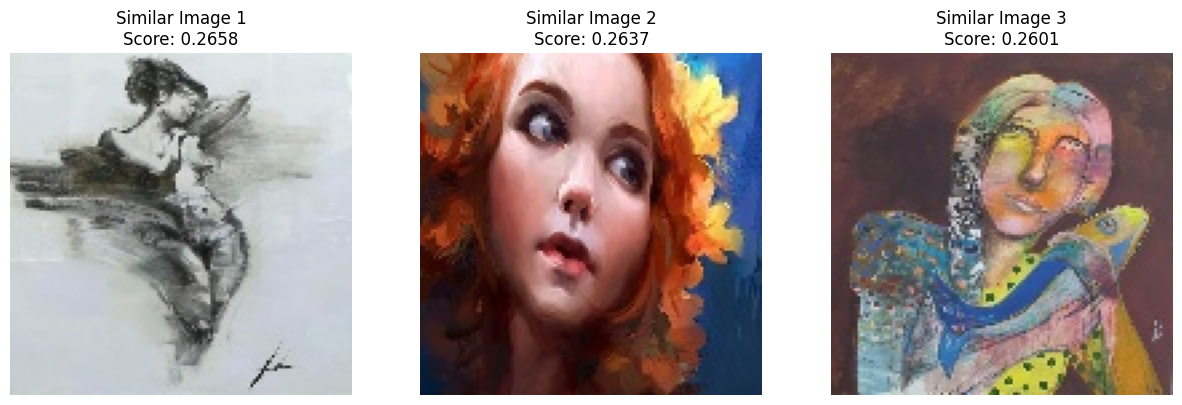

In [13]:
# Function to preprocess a single text query and return its embedding
def get_single_text_embedding(text):
    text_input = preprocess_text(text)
    with torch.no_grad():
        text_embedding = model.encode_text(text_input)
    text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
    return text_embedding.cpu().numpy()

import matplotlib.pyplot as plt

def find_most_similar_images_text(query_text, top_n=3):
    query_text_embedding = get_single_text_embedding(query_text)

    # Compute similarity scores
    similarity_scores = (image_embeddings @ query_text_embedding.T).squeeze().detach().cpu().numpy()

    # Get indices of the top N most similar images
    top_indices = similarity_scores.argsort()[-top_n:][::-1]

    # Display the most similar images
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(top_indices):
        similar_image_path = os.path.join(images_folder, data.iloc[idx]['image_id'])
        similar_image = Image.open(similar_image_path)

        plt.subplot(1, top_n, i + 1)
        plt.imshow(similar_image)
        plt.title(f"Similar Image {i+1}\nScore: {similarity_scores[idx]:.4f}")
        plt.axis('off')

    plt.show()

query_text = 'girl'
find_most_similar_images_text(query_text, top_n=3)

In [18]:
# Load and preprocess images
images = []
filenames = []
for filename in os.listdir(images_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(images_folder, filename)
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        images.append(image)
        filenames.append(filename)

# Encode images using CLIP model
with torch.no_grad():
    image_embeddings = torch.cat([model.encode_image(image) for image in images])

# Normalize features
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

def find_most_similar_images_text(query_text, top_n=3):
    query_text_embedding = get_single_text_embedding(query_text)

    # Compute similarity scores using cosine_similarity from sklearn
    similarity_scores = cosine_similarity(image_embeddings.cpu().numpy(), query_text_embedding).squeeze()

    # Get indices of the top N most similar images
    top_indices = similarity_scores.argsort()[-top_n:][::-1]

    # Display the most similar images
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(top_indices):
        similar_image_path = os.path.join(images_folder, filenames[idx])
        similar_image = Image.open(similar_image_path)

        plt.subplot(1, top_n, i + 1)
        plt.imshow(similar_image)
        plt.title(f"Similar Image {i+1}\nScore: {similarity_scores[idx]:.4f}")
        plt.axis('off')

    plt.show()

query_text = 'girl'
find_most_similar_images_text(query_text, top_n=3)

: 

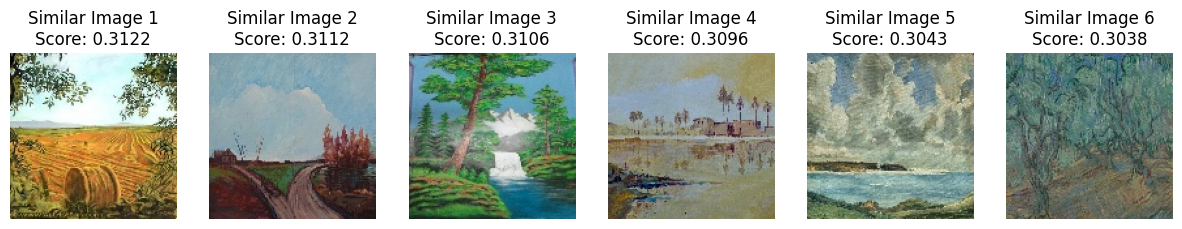

In [14]:
query_text = 'painting of an landscape'
find_most_similar_images_text(query_text, top_n=6)

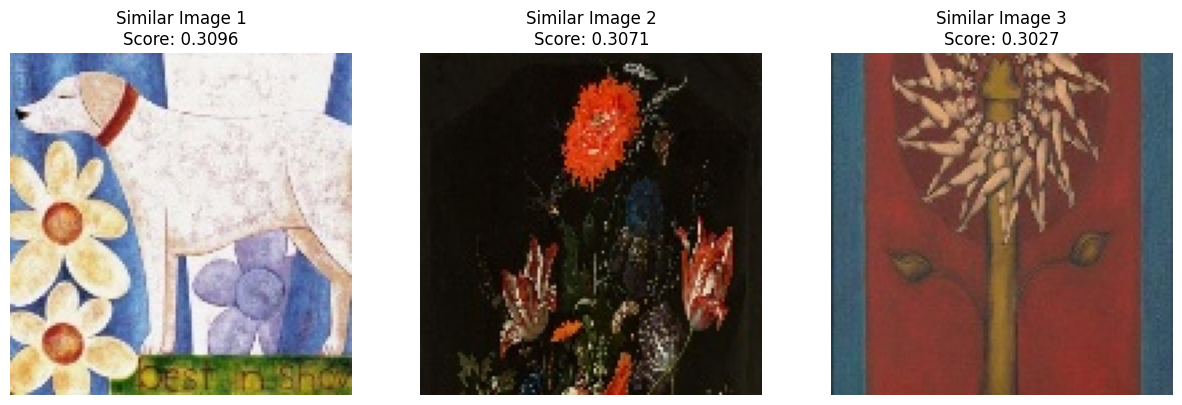

In [15]:
query_text = 'a painting of an animal with a flower on it '
find_most_similar_images_text(query_text, top_n=3)

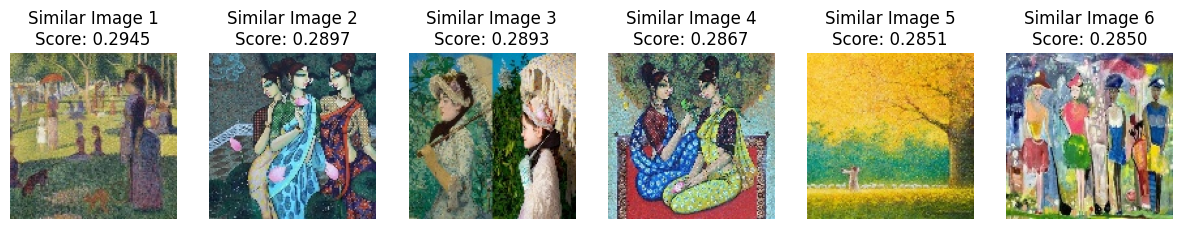

In [16]:
query_text = 'women in meadow '
find_most_similar_images_text(query_text, top_n=6)

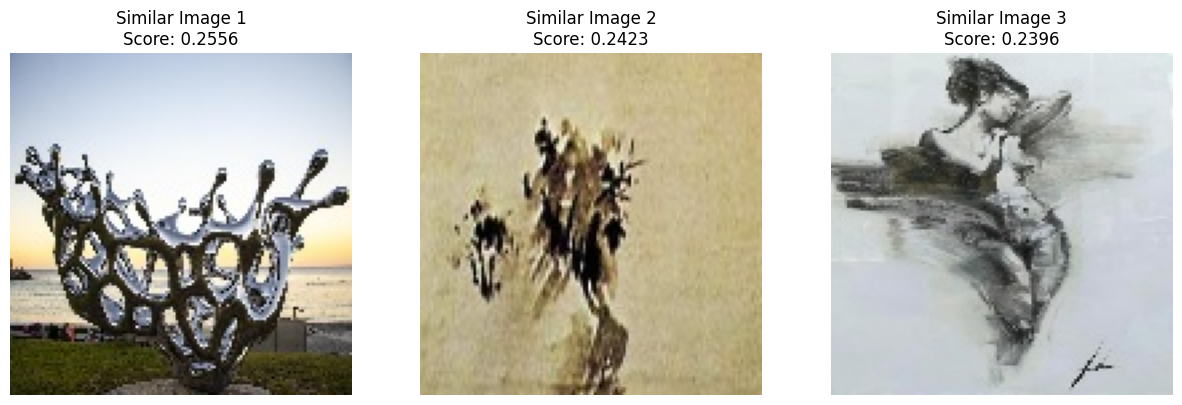

In [17]:
query_text = 'person riding bicycle'
find_most_similar_images_text(query_text, top_n=3)

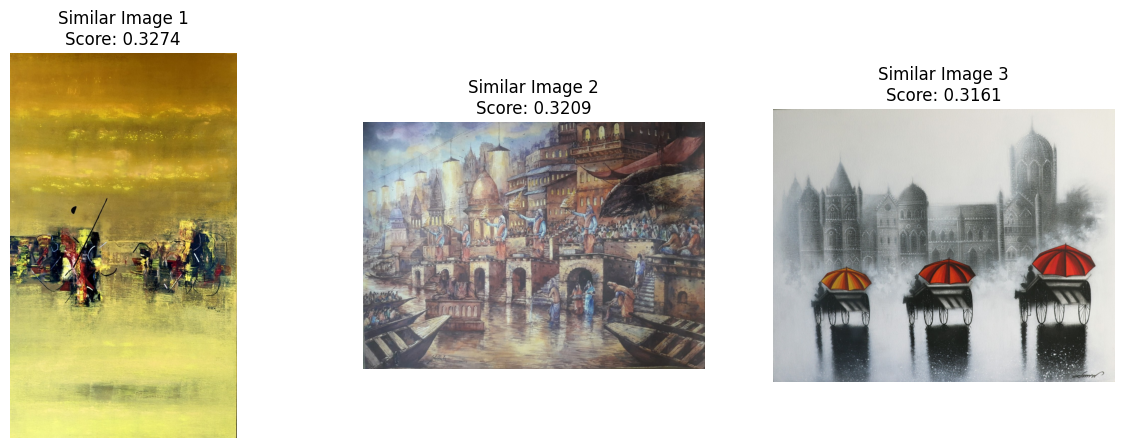

In [13]:
query_text = 'a painting of people with umbrellas '
find_most_similar_images_text(query_text, top_n=3)